In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from textblob import TextBlob

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
EPOCHS = 200
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
NODES = 1000
NUM_FEATURES = 30
NUM_CLASSES = 4

In [3]:
df = pd.read_csv("../data/Organic_extended_finalv3.csv", sep="|")

In [4]:
# Find max retweets
max_list = list()
for index, row in df.iterrows():
    num_list = list()
    num_list = {row["1"], row["2"],row["3"], row["4"],row["5"], row["6"]}
    max_list.append(max(num_list))
df["max_retweets"] = max_list

In [5]:
# Find mean/median and size
print("calculating mean/median")
mean =  df["max_retweets"].mean()
median = df["max_retweets"].median()
print("mean: ", mean)
print("median: ", median)
print("Number of entries: ", len(df))

calculating mean/median
mean:  149.06297636191212
median:  50.0
Number of entries:  28471


In [6]:
# Convert date strings to datetime objeccts
date_time = list()
for index, row in df.iterrows():
    if(row["created_time"].lower().islower()):
        # date time w/ letter (Jun, Mon, etc)
        date_time_obj = datetime.strptime(row["created_time"], '%a %b %d %H:%M:%S +0000 %Y')
        date_time.append(date_time_obj)
    else:
        # date time w/ not letters (Jun, Mon, etc)
        date_time_obj = datetime.strptime(row["created_time"], '%Y-%m-%d %H:%M:%S+00:00')
        date_time.append(date_time_obj)
df["created_datetime"] = date_time

In [7]:
# Add data for what day of week the article was published
df['is_mon'] = 0
df['is_tue'] = 0
df['is_wed'] = 0
df['is_thu'] = 0
df['is_fri'] = 0
df['is_sat'] = 0
df['is_sun'] = 0
df['is_weekend'] = 0

for index, row in df.iterrows():
    day = row["created_datetime"].weekday()
    if day is 0:
        df.at[index,'is_sun'] = 1
        df.at[index,'is_weekend'] = 1
    elif day is 1:
        df.at[index,'is_mon'] = 1
    elif day is 2:
        df.at[index,'is_tue'] = 1
    elif day is 3:
        df.at[index,'is_wed'] = 1
    elif day is 4:
        df.at[index,'is_thu'] = 1
    elif day is 5:
        df.at[index,'is_fri'] = 1
    elif day is 6:
        df.at[index,'is_sat'] = 1
        df.at[index,'is_weekend'] = 1

In [8]:
# Subjectivity and polarity
for index, row in df.iterrows():
    title_score = TextBlob(row["title"]).sentiment
    content_score = TextBlob(row["content"]).sentiment
    df.at[index,'title_polarity'] = title_score[0]
    df.at[index,'title_subjectivity'] = title_score[1]
    df.at[index,'content_polarity'] = content_score[0]
    df.at[index,'content_subjectivity'] = content_score[1]

In [9]:
# source
accounts = ["CNN","The Wall Street Journal","The Washington Post","NBC News",
            "The Associated Press","ABC News","Los Angeles Times","The New York Times","NPR","TIME","U.S. News","USA TODAY",
            "Fox News","Reuters","HuffPost"]
for i in accounts:
    df[i] = 0


for index, row in df.iterrows():
    df.at[index,row["screen_name"]] = 1
    

In [10]:
# 0 -> 0-0.25 quantile
# 1 -> 0.26-0.50 quantile
# 2 -> < 0.51-0.75 quantile
# 3 -> >= 0.76-1.00 quantile


quan_dict=df.max_retweets.quantile([0.25, 0.5, 0.75])
one_quar = quan_dict[0.25]
two_quar = quan_dict[0.5]
three_quar = quan_dict[0.75]


#one_quar = 10
#two_quar = 100
#three_quar = 1000



print("1: ", one_quar, "2: ", two_quar, "3: ", three_quar)

df.loc[df['max_retweets'] <= one_quar, 'shares'] = 0
df.loc[((df['max_retweets'] > one_quar) & (df['max_retweets'] <= two_quar)), 'shares'] = 1
df.loc[((df['max_retweets'] > two_quar) & (df['max_retweets'] <= three_quar)), 'shares'] = 2
df.loc[df['max_retweets'] > three_quar, 'shares'] = 3

1:  24.0 2:  50.0 3:  110.0


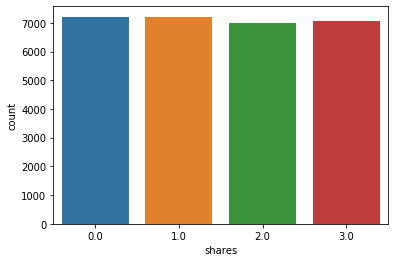

In [11]:
sns.countplot(x = 'shares', data=df)

In [12]:
df.head()

,Unnamed: 0,tweet_id,created_time,count,1,2,3,4,5,6,...,Los Angeles Times,The New York Times,NPR,TIME,U.S. News,USA TODAY,Fox News,Reuters,HuffPost,shares
0,0,1272217655630458881,2020-06-14 17:21:40+00:00,17,454,463.0,462.0,464.0,464.0,466.0,...,1,0,0,0,0,0,0,0,0,2.0
1,1,1272216897237516289,2020-06-14 17:18:39+00:00,17,163,163.0,163.0,163.0,162.0,162.0,...,0,0,0,0,0,0,0,0,0,2.0
2,2,1272220034065186817,2020-06-14 17:31:07+00:00,17,910,927.0,929.0,933.0,934.0,936.0,...,0,0,0,0,0,0,0,0,0,2.0
3,3,1272219784743202816,2020-06-14 17:30:08+00:00,17,2352,2377.0,2381.0,2378.0,2376.0,2373.0,...,0,1,0,0,0,0,0,0,0,3.0
4,4,1272220746014572545,2020-06-14 17:33:57+00:00,17,241,267.0,267.0,267.0,267.0,267.0,...,1,0,0,0,0,0,0,0,0,2.0


In [12]:
df = df.drop(['tweet_id','created_time','count','1','2','3','4','5','6','user_id','screen_name','title','content','url','expanded_url','created_datetime','max_retweets'], axis = 1)
X = df.iloc[:, 1:-1]
y = df.iloc[:,-1]

In [13]:
pd.set_option('display.max_columns', None)
len(X.columns)
X.head()

,follower_count,title_len,content_len,is_mon,is_tue,is_wed,is_thu,is_fri,is_sat,is_sun,is_weekend,title_polarity,title_subjectivity,content_polarity,content_subjectivity,CNN,The Wall Street Journal,The Washington Post,NBC News,The Associated Press,ABC News,Los Angeles Times,The New York Times,NPR,TIME,U.S. News,USA TODAY,Fox News,Reuters,HuffPost
0,3634148.0,8,369,0,0,0,0,0,1,0,1,-0.166667,0.433333,0.072377,0.383025,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,15735968.0,14,1766,0,0,0,0,0,1,0,1,0.016667,0.266667,0.019223,0.347613,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,48817611.0,15,190,0,0,0,0,0,1,0,1,0.075000,0.216667,0.209750,0.475417,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,46861284.0,9,4174,0,0,0,0,0,1,0,1,0.033333,0.066667,0.017214,0.481129,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3634146.0,16,2826,0,0,0,0,0,1,0,1,0.418182,0.627273,0.066627,0.399637,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [14]:
y

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
28466    1.0
28467    3.0
28468    3.0
28469    3.0
28470    0.0
Name: shares, Length: 28471, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [15]:
type(y_train)

pandas.core.series.Series

In [15]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


In [16]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.LongTensor(y_train))

## test data    
class testData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test), torch.LongTensor(y_test))

In [25]:
def get_class_distribution(obj):
    count_dict = {
        "0":0,
        "1":0,
        "2":0,
        "3":0
    }
    
    for i in obj:
        if i == 0:
            count_dict["0"] += 1
        elif i == 1:
            count_dict["1"] += 1
        elif i == 2:
            count_dict["2"] += 1
        else:
            count_dict["3"] += 1
    return count_dict

In [26]:
target_list = []

for _, t in train_data:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [27]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

tensor([0.0002, 0.0002, 0.0002, 0.0002])


In [28]:
class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all, 
    num_samples = len(class_weights_all),
    replacement = True
)

In [29]:
#train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=weighted_sampler)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        # Number of input features is 30.
        self.layer_1 = nn.Linear(num_feature, 2048) 
        self.layer_2 = nn.Linear(2048, 1024)
        self.layer_3 = nn.Linear(1024, 256)
        #self.layer_3 = nn.Linear(NODES, NODES)
        #self.layer_4= nn.Linear(NODES, NODES)
        self.layer_out = nn.Linear(256, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(256)
        #self.batchnorm4 = nn.BatchNorm1d(NODES)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
       #x = self.relu(self.layer_4(x))
       #x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
model = MulticlassClassification(num_feature=NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
#criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=30, out_features=2048, bias=True)
  (layer_2): Linear(in_features=2048, out_features=1024, bias=True)
  (layer_3): Linear(in_features=1024, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [33]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [34]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = multi_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 1.30281 | Acc: 0.000
Epoch 002: | Loss: 1.20304 | Acc: 0.000
Epoch 003: | Loss: 1.19698 | Acc: 0.000
Epoch 004: | Loss: 1.18410 | Acc: 0.000
Epoch 005: | Loss: 1.18083 | Acc: 0.000
Epoch 006: | Loss: 1.17955 | Acc: 0.000
Epoch 007: | Loss: 1.17710 | Acc: 0.000
Epoch 008: | Loss: 1.17468 | Acc: 0.000
Epoch 009: | Loss: 1.17371 | Acc: 0.000
Epoch 010: | Loss: 1.16546 | Acc: 0.000
Epoch 011: | Loss: 1.16027 | Acc: 0.000
Epoch 012: | Loss: 1.16118 | Acc: 4.348
Epoch 013: | Loss: 1.15800 | Acc: 0.000
Epoch 014: | Loss: 1.15862 | Acc: 4.348
Epoch 015: | Loss: 1.15229 | Acc: 0.000
Epoch 016: | Loss: 1.15113 | Acc: 0.000
Epoch 017: | Loss: 1.15282 | Acc: 4.348
Epoch 018: | Loss: 1.13639 | Acc: 0.000
Epoch 019: | Loss: 1.13634 | Acc: 4.348
Epoch 020: | Loss: 1.13260 | Acc: 8.696
Epoch 021: | Loss: 1.13511 | Acc: 8.696
Epoch 022: | Loss: 1.13740 | Acc: 4.348
Epoch 023: | Loss: 1.12419 | Acc: 13.043
Epoch 024: | Loss: 1.12706 | Acc: 8.696
Epoch 025: | Loss: 1.13066 | Acc: 8.696

Epoch 198: | Loss: 0.29248 | Acc: 100.000
Epoch 199: | Loss: 0.28928 | Acc: 100.000
Epoch 200: | Loss: 0.29028 | Acc: 100.000


In [35]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [36]:
confusion_matrix(y_test, y_pred_list)


array([[656, 392, 268, 143],
       [402, 435, 385, 223],
       [235, 305, 418, 421],
       [132, 183, 413, 684]], dtype=int64)

In [37]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

         0.0       0.46      0.45      0.45      1459
         1.0       0.33      0.30      0.32      1445
         2.0       0.28      0.30      0.29      1379
         3.0       0.46      0.48      0.47      1412

    accuracy                           0.39      5695
   macro avg       0.38      0.38      0.38      5695
weighted avg       0.39      0.39      0.38      5695

